In [199]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import recharge_funcs as rf
import baseflow
from pathlib import Path
import sys
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#Scalable, Normalize
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#segoe UI
plt.rcParams['font.family'] = 'Segoe UI'

#### Model Evaluation
Seasonal comparison of discharge and baseflow

In [2]:
models = ["GFDL-ESM4", "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MRI-ESM2-0", "UKESM1-0-LL"]

#station coordinates
station_locations = pd.read_csv("mHM_eval_stations.csv")
#Boundaries data
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp")

#rivers
rivers_shp = gpd.read_file(r"W:/VUB/_main_research/data/shapefiles/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu_shp/hydroRivers_BE.shp")

#Open picked flow data for evaluation stations
with open("eval_stations_Q.pickle", "rb") as f:
    eval_Obs = pickle.load(f)

#read validation stations (NSE>0) #from the flow_validation notebook
val_gdf = pd.read_csv('validation_stations_NSE_above_0.csv')

#Canals to be removed
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

#Extract only stations in val_gdf
eval_Obs = {k: v for k, v in eval_Obs.items() if k in val_gdf['name'].values}

# Remove canal stations
eval_Obs = {k: v for k, v in eval_Obs.items() if k not in canals}

seasons = ['DJF', 'MAM', 'JJA', 'SON']

season_map = {12:"DJF",1:"DJF",2:"DJF",
            3:"MAM",4:"MAM",5:"MAM",
            6:"JJA",7:"JJA",8:"JJA",
            9:"SON",10:"SON",11:"SON"}

scenarios = ['historical', 'ssp370', 'ssp585']

##### Seasonal comparison of per-station Q

In [3]:
base_sim_dir = "./isimip_Q"
sim_subfolder = "Qrouted"

#Extract and seasonalize total discharge
# model_seasons_df = rf.seasonal_Q_comparison(base_sim_dir, sim_subfolder, models, eval_Obs, season_map)


In [4]:
#extract multistation baseflow
baseflow_models, all_models_BFI, best_method = rf.extract_multistation_baseflow(base_sim_dir, sim_subfolder, models, eval_Obs)

Extracting baseflow for ZOUTLEEUW_KLEINE GETE                                                

In [70]:
ensemble_bfi = pd.concat(
        [df.set_index('name') for df in all_models_BFI.values()],
        axis=0
    )

In [ ]:
#seasonalize baseflow
Q_names = ['obs_Qb', 'sim_Qb '] #correspond to headers in baseflow_models
seasonal_bf = rf.seasonal_baseflow_analysis(baseflow_models, models, season_map, Q_names)

##### Comparison scatterplots

In [ ]:
# rf.plot_multimodel_spread(model_seasons_df, seasons,
#                        "q_obs", 'q_model',
#                        xlabel="Observed seasonal flow",
#                        ylabel="Simulated seasonal flow")

In [ ]:
# rf.plot_multimodel_spread(seasonal_bf, seasons,
#                        'obs_Qb', 'sim_Qb',
#                        xlabel="Observed seasonal baseflow",
#                        ylabel="Simulated seasonal baseflow")

In [71]:
ensemble_bfi_df=rf.ensemble_station_BFI(all_models_BFI)

In [ ]:
obs_BFI_df=all_models_BFI['GFDL-ESM4']
bfi_diff_gdf = rf.ensemble_BFI_to_geodataframe(ensemble_bfi_df, obs_BFI_df,station_locations)

In [ ]:
m_diff, pw = rf.wilcoxon_stats(bfi_diff_gdf)

In [ ]:
rf.map_BFI_anomalies(bfi_diff_gdf, be_shp, rivers_shp, m_diff, pw)


#### Projected changes

In [93]:
def extract_scenario_multistation_baseflow(base_sim_dir, sim_subfolder, models, eval_Obs, best_bfi_method_dict):
    """  
    Extract baseflow time series for each station and model using the best method based on observed data.  
    Parameters  
    ----------
    base_sim_dir : str
        Base directory containing model subdirectories.
    sim_subfolder : str
        Subfolder within each model directory containing simulation CSV files.
    models : list of str
        List of model names corresponding to subdirectory names.
    eval_Obs : dict  
        Dictionary of observed discharge time series (keyed by station name). 
    best_bfi_method_dict: dict
        Dictionary containing best baseflow extraction method per station, based on observed data.

    Returns  
    -------
    dict of pd.DataFrame  
        Dictionary with model names as keys and DataFrames with baseflow time series as values.
    """
    # Ensure station names are uppercase for consistency
    eval_Obs_upper = rf.keys_upper(eval_Obs)

    all_models_Qb = {}
    all_models_BFI = {}

    for model in models:
        print(f'\nExtracting baseflow for {model}...')
        sim_dir = Path(base_sim_dir) / model / sim_subfolder
        stations_Qb = []
        stations_BFI = []

        for fpath in sorted(sim_dir.glob("*.csv")):
            station_name = fpath.stem.upper()

            if station_name not in eval_Obs_upper:
                continue

            sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

            #select best method based on observed baseflow separation
            if station_name not in best_bfi_method_dict:
                continue

            bfi_method=best_bfi_method_dict[station_name]

            #extract baseflow
            msg = f"Extracting baseflow for {station_name}"
            sys.stdout.write("\r" + msg + "  " * 20)
            sys.stdout.flush()

            #use the same best method to extract the baseflow from the simulated Q
            sim_bf_dict, sim_bfi = baseflow.separation(sim_Q, return_bfi=True, return_kge=False, method=bfi_method)
            sim_Qb= sim_bf_dict[bfi_method]
            sim_bfi = sim_bfi[bfi_method]

            sim_Qb.columns = ['sim_Qb']
            sim_Qb['station'] = station_name
            
            #rearrange columns
            sim_Qb=sim_Qb[["station", 'sim_Qb']]
            stations_Qb.append(sim_Qb)

            #bfi data
            sim_bfi_df=pd.DataFrame({"sim_bfi":sim_bfi.values})
            sim_bfi_df['name'] = station_name
            sim_bfi_df['model'] = model

            sim_bfi_df=sim_bfi_df[["name","sim_bfi", "model"]]
            stations_BFI.append(sim_bfi_df)

        if stations_Qb:
            model_bf_df = pd.concat(stations_Qb)
            model_bf_df['model'] = model
            all_models_Qb[model] = model_bf_df
        
        if stations_BFI:
            model_bfi_df = pd.concat(stations_BFI)
            model_bfi_df['model'] = model
            # Optionally store BFI data if needed
            all_models_BFI[model] = model_bfi_df

    return all_models_Qb, all_models_BFI

In [11]:
def seasonal_baseflow_analysis(all_models_Qb, models, season_map, Q_names):
    """  
    Analyze seasonal mean baseflow for each station and model.  
    Parameters  
    ----------
    all_models_Qb : dict of pd.DataFrame  of models and station baseflow
        Dictionary with model names as keys and DataFrames with baseflow time series as values.  
    models : list of str  
        List of model names corresponding to keys in all_models_Qb.  
    season_map : dict
        Mapping of month numbers to season labels.  
    Q_names: list  
        Name of discharge to groupby e.g. ["obs_Qb","sim_Qb"]

    Returns  
    -------
    pd.DataFrame  
        DataFrame with columns ['name', 'model', 'season', 'obs_Qb', 'sim_Qb'] containing seasonal mean baseflow.  
    """

    seasonal_baseflow = []

    # Initialize a dictionary to hold seasonal data for the station
    for model in models:
        model_df = all_models_Qb[model]

        stations_Qb = []  # <-- collect per model

        for nameStation in model_df['station'].unique():

            station_df = model_df[model_df['station'] == nameStation]
            
            station_df = station_df.copy()
            station_df["season"] = station_df.index.month.map(season_map)

            # seasonal climatology
            season_Qb = station_df.groupby("season")[Q_names].mean().reset_index()
            season_Qb["name"] = nameStation
            season_Qb["model"] = model
            stations_Qb.append(season_Qb)
        
        if stations_Qb:  # <-- use the correct list
            model_Qb_df = pd.concat(stations_Qb)
            seasonal_baseflow.append(model_Qb_df)
        
        #convert to dataframe
    seasonal_baseflow_df = pd.concat(seasonal_baseflow)
    #rearrange columns
    seasonal_baseflow_df = seasonal_baseflow_df[["name", "model", "season"] + Q_names]

    return seasonal_baseflow_df

In [90]:
#Calculate multimodel ensemble BFI mean
def ensemble_station_BFI(all_models_BFI, sim_name):
    """  
    Concatenate simulated BFI from multiple model dictionaries
    ----------
    Parameters:
    all_model_BFI: dict  
    Dictionary containing individual model station dataframes of BFI, indexed by model name
    smi_name: str
    name of simulate Q variable

    ----------
    Returns:  
    df: ensemble average dataframe of average per station BFI
    """
    # Combine all model BFIs by 'name'
    ensemble_bfi = pd.concat(
        [df.set_index('name')[sim_name] for df in all_models_BFI.values()],
        axis=1
    )

    # Compute mean across models
    ensemble_bfi_mean = ensemble_bfi.mean(axis=1, skipna=True)

    # Convert to final DataFrame
    ensemble_bfi_df = ensemble_bfi_mean.reset_index()
    ensemble_bfi_df.columns = ['name', 'ens_BFI']

    return ensemble_bfi_df

#======================================================================
def df_to_gdf(df, stations_df):
    """ Convert dataframe to geodataframe by combining with df with station coordinates"""
    #change station_locations to upper
    stations_df['name'] = stations_df['name'].str.upper()

    #only unique station names
    station_locations_df = stations_df.drop_duplicates(subset='name').set_index('name')

    #merge station_locations with df on 'name'
    ensemble_stations = pd.concat([station_locations_df, df], axis=1).dropna()

    #to geodataframe
    gdf_ = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(ensemble_stations['lon'], ensemble_stations['lat']))
    gdf_.crs = "EPSG:4326"

    return gdf_

##### Extract seasona flow for future scenarios

In [ ]:
Q_names=['sim_Qb']

baseflow_scenarios = {}
bfi_scenarios={}
#changes in baseflow under respective scenarios
for scenario in scenarios:
    base_sim_dir = f"./isimip_Q/{scenario}"
    sim_subfolder = "Qrouted"

    #Extract and seasonalize total discharge
    print(f"\nextracting baseflow for {scenario}")
    scenario_BF_models, all_models_BFI = extract_scenario_multistation_baseflow(base_sim_dir, sim_subfolder, models, eval_Obs, best_method)
    
    seasonal_bf=seasonal_baseflow_analysis(scenario_BF_models, models, season_map, Q_names)

    baseflow_scenarios[scenario] = seasonal_bf

    ensemble_scenario_bfi = pd.concat(
        [df.set_index('name') for df in all_models_BFI.values()],
        axis=0
    )
    ensemble_scenario_bfi['scenario'] = scenario
    bfi_scenarios[scenario] = ensemble_scenario_bfi

##### Compute Projected changes under CC

In [150]:
bfi_delta_gdf={}

#annual projected baseflow changes
future_scenarios = ['ssp370', 'ssp585']
hist_bf_df=baseflow_scenarios['historical'].groupby('name').mean(numeric_only=True)
for scenario in future_scenarios:
    scenario_df=baseflow_scenarios[scenario].groupby('name').mean(numeric_only=True)
    bf_change_df= 100 * (scenario_df - hist_bf_df)/hist_bf_df

    #convert to gdf for mapping
    bf_change_gdf = df_to_gdf(bf_change_df, station_locations)
    bfi_delta_gdf[scenario] = bf_change_gdf

In [152]:
df11 = baseflow_scenarios[scenario].groupby(['name','season']).mean(numeric_only=True)
df12 = baseflow_scenarios['historical'].groupby(['name','season']).mean(numeric_only=True)

In [259]:
dfx = 100*(df11 - df12)/df12
dfx.reset_index(inplace=True)
df_djf=dfx[dfx['season']=='MAM']

station_locations.set_index('name')
df_djf.set_index('name', inplace=True)

In [260]:
dfx_gdf = df_to_gdf(df_djf, station_locations)

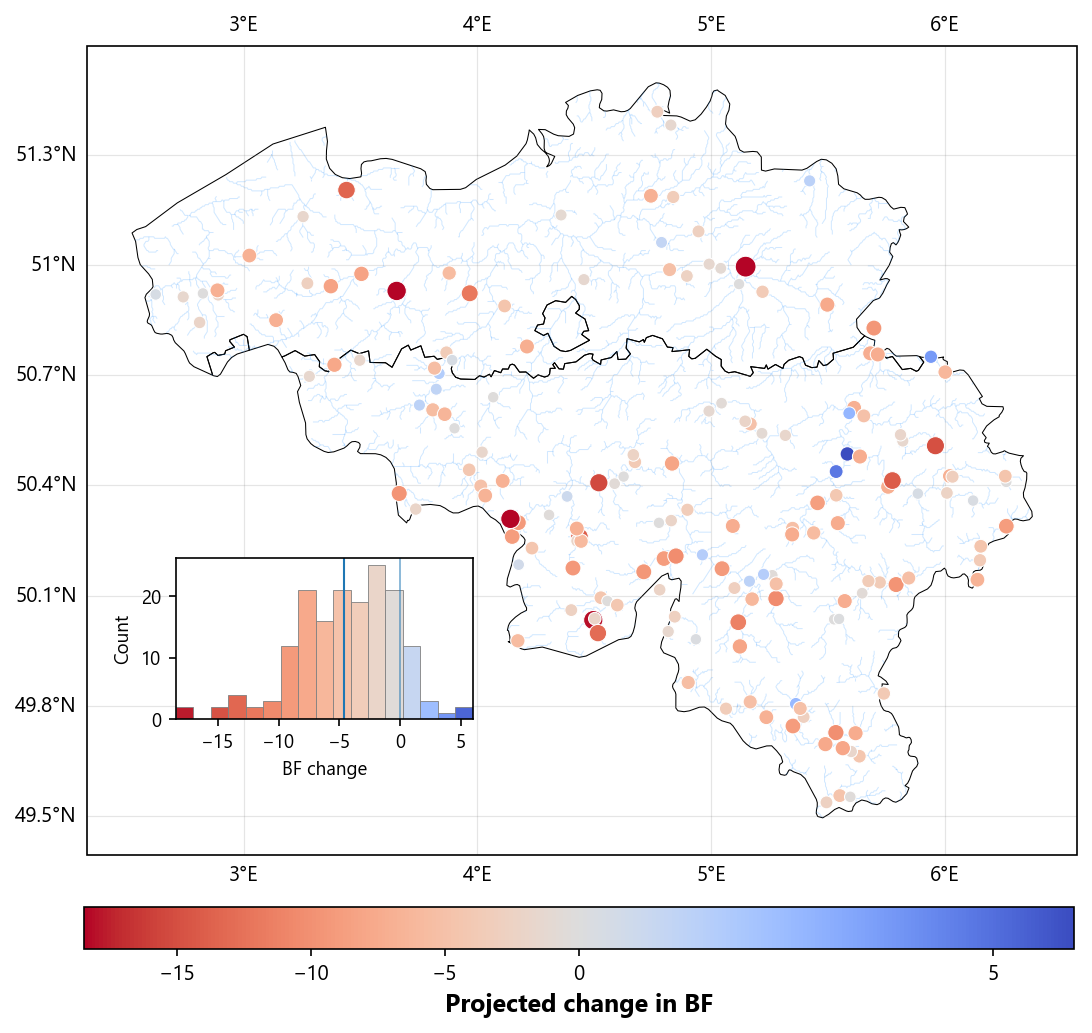

In [261]:
#Map the differences
fig, ax, cbar, ax_hist, sc = map_baseflow_stats(
    dfx_gdf, be_shp, rivers_shp, 'sim_Qb', 'coolwarm_r'
)

# Tweak labels/titles afterwards
cbar.set_label('Projected change in BF', fontsize=12)
ax_hist.set_xlabel('BF change', fontsize=10)
ax_hist.set_ylabel('Stations', fontsize=10)
ax_hist.set_xlabel('BF change', fontsize=9)
ax_hist.set_ylabel('Count', fontsize=9)
ax_hist.tick_params(labelsize=9)

plt.show()

In [ ]:
def map_baseflow_stats(
    bf_gdf, boundaries_shp, streams_shp, bf_var, c_map,
    ax=None, cax=None
):
    """
    Map differences between obs. and sim. BFI per station overlain over a map and river network.
    Returns figure/axes handles so labels can be customized outside.
    """

    # Create fig/ax if not provided
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
        created_fig = True
    else:
        fig = ax.figure

    # Background layers
    boundaries_shp.plot(ax=ax, linewidth=0.5, edgecolor='black', facecolor='none',
                        zorder=1, transform=ccrs.PlateCarree())

    streams_shp.plot(ax=ax, linewidth=0.5, alpha=0.2, edgecolor='dodgerblue',
                     facecolor='none', zorder=2, transform=ccrs.PlateCarree())

    vals = bf_gdf[bf_var].to_numpy()

    # Color: diverging centered at 0 (robust limits)
    p1, p99 = np.nanpercentile(vals, [1, 100])
    vmin, vmax = p1, p99
    
    eps = 1e-6
    if vmax <= 0:  # all data ≤ 0 -> keep a tiny positive headroom
        vmax = eps
    if vmin >= 0:  # all data ≥ 0 -> keep a tiny negative headroom
        vmin = -eps

    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    cmap_name = c_map
    cmap = plt.get_cmap(cmap_name)
    sm = ScalarMappable(norm=norm, cmap=cmap)  # single source of truth


    # Size: scale |diff|
    mag = np.abs(vals)
    smin, smax = 30, 100
    if np.nanmax(mag) > np.nanmin(mag):
        sizes = np.interp(mag, [np.nanmin(mag), np.nanmax(mag)], [smin, smax])
    else:
        sizes = np.full_like(mag, (smin + smax) / 2.0)

    sc = ax.scatter(
        bf_gdf.geometry.x,
        bf_gdf.geometry.y,
        c=vals, s=sizes,
        cmap=cmap, norm=norm,
        edgecolor='white', linewidth=0.5,
        transform=ccrs.PlateCarree(), zorder=3,
    )

    # Gridlines
    gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
    gl.top_labels = True
    gl.right_labels = False

    # Inset histogram
    ax_hist = inset_axes(ax, width="30%", height="20%",
                     bbox_to_anchor=(-.60, -.62, 1.0, 1.0),
                     bbox_transform=ax.transAxes)

    # histogram
    counts, bins, patches = ax_hist.hist(vals, bins=20)
    centers = 0.5 * (bins[:-1] + bins[1:])

    # color bars with the SAME mapping as the scatter/colorbar
    for c, p in zip(centers, patches):
        p.set_facecolor(sm.to_rgba(c))
        p.set_edgecolor('gray')
        p.set_linewidth(0.4)

    # reference lines/annotations
    ax_hist.axvline(np.nanmean(vals), linewidth=1)
    ax_hist.axvline(0, lw=0.8, alpha=0.6)
    ax_hist.set_xlim(vmin, vmax)

    # Colorbar: use provided cax or create a default one
    if cax is None:
        # default horizontal colorbar under the map
        cax = fig.add_axes([0.291, 0.02, 0.44, 0.04])
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    cbar.set_label('BFI Difference', fontsize=10, weight='bold')
    cbar.ax.tick_params(labelsize=10)

    # Return handles so caller can customize
    return fig, ax, cbar, ax_hist, sc
